# Processing of triggerlessly acquired detector's data
## PREPROCESSING

Load and pepare the dataset inside a Pandas' DataFrame

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# Prepare the path to the file
directory = "~/data/"
file_name = "data_000000.txt"

# Load the dataset
data = pd.read_csv(directory + file_name)

# Useful constants
Tmax = 390 # ns
L = 42 # mm
Vd = L/(2*Tmax) # mm/ns
pos_offset = 21 # mm

# Add column of time (ns)
# There is a problem with the precision of the measures
# Real time: data['TIME_NS'] = data["ORBIT_CNT"]*3564*25 + data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30
data['TIME_NS'] = data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30

# Show first 5 rows
data.head(5)

def compute_t0(tR1, tR2, tR3):
    return (tR1 - tR3)/2 + tR2 - Tmax

# To get the layer we must get the remainder of the TDC_CHANNEL with 4
# Then we must reoder the result as described above
data['LAYER'] = data['TDC_CHANNEL'] % 4

# Create mask to adjust labels
mask = data == 'inf' # Trick: I want an equivalent DataFrame with all False

# Map 1 --> 4
data.loc[data['LAYER'] == 1,'LAYER'] = 4

# Map 0 -> 1
data.loc[data['LAYER'] == 0,'LAYER'] = 1

# Check the correctness
data.head(5)

# Create column for chamber
# Create mask to adjust labels
mask = data == 'inf' # Trick: I want an equivalent DataFrame with all False

# Before create empty column
data['CHAMBER'] = 0

# Detector 1
# Select all rows with FPGA = 0 and TDC_CHANNEL <= 64
mask['CHAMBER'] = ((data['FPGA'] == 0) & (data['TDC_CHANNEL'] <= 64))
data[mask] = 1

# Detector 2
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
mask['CHAMBER'] = ((data['FPGA'] == 0) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128))
data[mask] = 2

# Detector 3
# Select all rows with FPGA = 1 and TDC_CHANNEL <= 64
mask['CHAMBER'] = ((data['FPGA'] == 1) & (data['TDC_CHANNEL'] <= 64))
data[mask] = 3

# Detector 4
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
mask['CHAMBER'] = ((data['FPGA'] == 1) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128))
data[mask] = 4

# Check the correctness
data.head(5)

# Create column for chamber
data['CELL'] = ((data['TDC_CHANNEL']%64)/4).apply(np.ceil)

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL
0,1,1,45,1920954526,2363,4,59078.333333,4,3,12.0
1,1,1,77,1920954526,2357,29,58949.166667,4,4,4.0
2,1,1,20,1920954526,2361,20,59041.666667,1,3,5.0
3,1,1,40,1920954526,2364,28,59123.333333,1,3,10.0
4,1,1,96,1920954526,2358,29,58974.166667,1,4,8.0


## PART 1
To Detect the events we can use the trigger 139

In [48]:
# Silence warning
pd.options.mode.chained_assignment = None  # default='warn'

# Search all the orbit with the trigger 139
orbit = data.loc[data['TDC_CHANNEL']==139,'ORBIT_CNT']
list_orbit = orbit.values.tolist()
events = data.loc[data['ORBIT_CNT'].isin(list_orbit)]

# Sort data
events = events.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])

# Compute t0
# Make three shifted copy of the LAYER column nd of TIME_NS
events['LAYER_1'] = events['LAYER'].shift(-1)
events['LAYER_2'] = events['LAYER'].shift(-2)
events['TIME_NS_1'] = events['TIME_NS'].shift(-1)
events['TIME_NS_2'] = events['TIME_NS'].shift(-2)

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2
37,1,1,21,1920954537,2645,1,66125.833333,4,3,6.0,4.0,2.0,66195.833333,66112.500000
40,1,1,21,1920954537,2647,25,66195.833333,4,3,6.0,2.0,3.0,66112.500000,65995.000000
39,1,1,22,1920954537,2644,15,66112.500000,2,3,6.0,3.0,1.0,65995.000000,66053.333333
33,1,1,23,1920954537,2639,24,65995.000000,3,3,6.0,1.0,4.0,66053.333333,65990.833333
35,1,1,24,1920954537,2642,4,66053.333333,1,3,6.0,4.0,2.0,65990.833333,65985.000000


In [49]:
# Remove the trigger 139
events = events[events['TDC_CHANNEL']<129]

# Search pattern 1-2-3 or 2-3-4 to apply the Talete's Theorem for t0
events['temp'] = (events['TIME_NS']-events['TIME_NS_2'])/2 + events['TIME_NS_1']-Tmax

# Search pattern to get the real t0
mask_pattern_1 = (events['LAYER']==1) & (events['LAYER_1']==2) & (events['LAYER_2']==3)
mask_pattern_2 = (events['LAYER']==2) & (events['LAYER_1']==3) & (events['LAYER_2']==4)

# Compute real t0
events['t0'] = events.loc[mask_pattern_1, 'temp']
# Populate values of adiacent cell
events = events.fillna(0)
events['t0'] = events['t0'] + events['t0'].shift(1) + events['t0'].shift(2)
events = events.fillna(0)

# Compute the position
events['POSITION'] = events['t0']*Vd

events.head(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,temp,t0,POSITION
37,1,1,21,1920954537,2645,1,66125.833333,4,3,6.0,4.0,2.0,66195.833333,66112.500000,65812.500000,0.0,0.0
40,1,1,21,1920954537,2647,25,66195.833333,4,3,6.0,2.0,3.0,66112.500000,65995.000000,65822.916667,0.0,0.0
39,1,1,22,1920954537,2644,15,66112.500000,2,3,6.0,3.0,1.0,65995.000000,66053.333333,65634.583333,0.0,0.0
33,1,1,23,1920954537,2639,24,65995.000000,3,3,6.0,1.0,4.0,66053.333333,65990.833333,65665.416667,0.0,0.0
35,1,1,24,1920954537,2642,4,66053.333333,1,3,6.0,4.0,2.0,65990.833333,65985.000000,65635.000000,0.0,0.0
34,1,1,85,1920954537,2639,19,65990.833333,4,4,6.0,2.0,3.0,65985.000000,66116.666667,65532.083333,0.0,0.0
36,1,1,86,1920954537,2639,12,65985.000000,2,4,6.0,3.0,1.0,66116.666667,65872.500000,65782.916667,0.0,0.0
38,1,1,87,1920954537,2644,20,66116.666667,3,4,6.0,1.0,3.0,65872.500000,66025.000000,65528.333333,0.0,0.0
31,1,1,88,1920954537,2634,27,65872.500000,1,4,6.0,3.0,2.0,66025.000000,41975.833333,77583.333333,0.0,0.0
41,1,1,38,1920954543,1679,1,41975.833333,2,3,10.0,4.0,3.0,60938.333333,60696.666667,51187.916667,0.0,0.0


In [58]:
# Map obit values to a range of int
grouped_orbit = events.groupby('ORBIT_CNT')
# Search all orbits
orbits = list(grouped_orbit.groups.keys())
# Create increasing number list for the events
event_number = np.arange(1, len(orbits)+1)
# Create the map
event_map = dict(zip(orbits, event_number))
# Map values
orbit_to_map = events['ORBIT_CNT']
orbit_mapped = orbit_to_map.map(event_map)
events['EVENT_NUMBER'] = orbit_mapped
events.head(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,temp,t0,POSITION,EVENT_NUMBER
37,1,1,21,1920954537,2645,1,66125.833333,4,3,6.0,4.0,2.0,66195.833333,66112.500000,65812.500000,0.0,0.0,1
40,1,1,21,1920954537,2647,25,66195.833333,4,3,6.0,2.0,3.0,66112.500000,65995.000000,65822.916667,0.0,0.0,1
39,1,1,22,1920954537,2644,15,66112.500000,2,3,6.0,3.0,1.0,65995.000000,66053.333333,65634.583333,0.0,0.0,1
33,1,1,23,1920954537,2639,24,65995.000000,3,3,6.0,1.0,4.0,66053.333333,65990.833333,65665.416667,0.0,0.0,1
35,1,1,24,1920954537,2642,4,66053.333333,1,3,6.0,4.0,2.0,65990.833333,65985.000000,65635.000000,0.0,0.0,1
34,1,1,85,1920954537,2639,19,65990.833333,4,4,6.0,2.0,3.0,65985.000000,66116.666667,65532.083333,0.0,0.0,1
36,1,1,86,1920954537,2639,12,65985.000000,2,4,6.0,3.0,1.0,66116.666667,65872.500000,65782.916667,0.0,0.0,1
38,1,1,87,1920954537,2644,20,66116.666667,3,4,6.0,1.0,3.0,65872.500000,66025.000000,65528.333333,0.0,0.0,1
31,1,1,88,1920954537,2634,27,65872.500000,1,4,6.0,3.0,2.0,66025.000000,41975.833333,77583.333333,0.0,0.0,1
41,1,1,38,1920954543,1679,1,41975.833333,2,3,10.0,4.0,3.0,60938.333333,60696.666667,51187.916667,0.0,0.0,2


In [63]:
# Final DataFrame
events_final = events[['EVENT_NUMBER','CHAMBER','LAYER','CELL','POSITION']]
events_final.set_index(['EVENT_NUMBER','CHAMBER','LAYER'], inplace=True)
events_final.sort_index(inplace=True)
events_final.head(10)

CELL  POSITION
EVENT_NUMBER CHAMBER LAYER                
1            3       1       6.0       0.0
                     2       6.0       0.0
                     3       6.0       0.0
                     4       6.0       0.0
                     4       6.0       0.0
             4       1       6.0       0.0
                     2       6.0       0.0
                     3       6.0       0.0
                     4       6.0       0.0
2            3       2      10.0       0.0

128


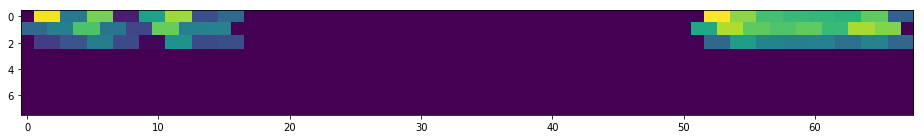

In [97]:
## SCRIVI QUI
events = events[events['TDC_CHANNEL']<129]
print(events['TDC_CHANNEL'].max())
raw_mat = np.zeros((16, 32))


plt.figure(figsize=(16,10))



rows = np.array((events['CHAMBER']-1)*4+events['LAYER']-1)
columns = np.array((events['CELL']-1)*2).astype(int)


for i in range(len(rows)):
    raw_mat[rows[i], columns[i]] = raw_mat[rows[i], columns[i]]+1
    raw_mat[rows[i], columns[i]+1] = raw_mat[rows[i], columns[i]+1]+1

#plt.imshow(raw_mat)
#plt.colorbar()

final_mat = np.zeros((8, 68))

for i in range(4):
    if (i%2 == 0):
        final_mat[i, 1:33] = raw_mat[i, :32]
    else:
        final_mat[i, :32] = raw_mat[i, :32]
for i in range(4, 8):
    if (i%2 == 0):
        final_mat[i-4, 36:68] = raw_mat[i, :32]
    else:
        final_mat[i-4, 35:67] = raw_mat[i, :32]    
#final_mat[0, 1:33] = raw_mat[0, :32]
#final_mat[1, :32] = raw_mat[1, :32]
#final_mat[2, 1:33] = raw_mat[2, :32]

plt.imshow(final_mat)


In [40]:
events.head(100)
np.array(rows)

8

In [ ]:
# Before this we have to solve the left/right ambiguity
# Add offset to the position
mask_layer = (events['LAYER'] == 1) | (events['LAYER'] == 3)
mask = mask_layer & (events['POSITION'] != 0)
events.loc[mask, 'POSITION'] = events['POSITION'] + pos_offset

In [ ]:
## Beware mortals, Marco has tamed the wild filter function!

grouped_orbit = data.groupby('ORBIT_CNT')
triggered_orbit = grouped_orbit.filter(lambda x: x['TDC_CHANNEL'].max()==139)
## Triggered_orbit è un dataframe contente tutti gli hit delle orbit che hanno il trigger 139
## Ci mette molto anche usando filter (meno di 5 minuti però, credo...)
triggered_orbit.head()
## Le orbit sembrano già essere in ordine crescente

In [ ]:
## TEST OCIO CHE CI METTE TANTISSIMISSIMO (Per ora teniamo quello di Boet)
## Lets costruiamo questo fucking dataframe
events = pd.DataFrame(columns=['EVENT','HIT','INFO','VALUE'])

## Eliminiamo le hit corrispondenti ai trigger
triggered_orbit = triggered_orbit[triggered_orbit['TDC_CHANNEL']<137]
gr_event = triggered_orbit.groupby('ORBIT_CNT')
 
## Ocio che ci mette molto tempo
event_counter = 0
row_counter = 0
for orb, group in gr_event:
    hit_counter = 1
    for row, data in group.iterrows():
        events.loc[row_counter] = [event_counter,hit_counter,'CHAMBER',data['CHAMBER']]
        events.loc[row_counter+1] = [event_counter,hit_counter,'LAYER',data['LAYER']]
        events.loc[row_counter+2] = [event_counter,hit_counter,'CELL',data['CELL']]
        events.loc[row_counter+3] = [event_counter,hit_counter,'POSITION',1]
        hit_counter += 1
        row_counter += 4
    event_counter += 1    
events.head()
## FUCK YEAH!

In [ ]:
## Lets costruiamo questo fucking dataframe
events = pd.DataFrame(columns=['ORBIT','CHAMBER','LAYER','CELL'])

## Eliminiamo le hit corrispondenti ai trigger
triggered_orbit = triggered_orbit[triggered_orbit['TDC_CHANNEL']<137]
gr_event = triggered_orbit.groupby('ORBIT_CNT')
 
## Ocio che ci mette molto tempo
c = 0
for orb, gr in gr_event:
    for i in range(len(gr)):
        events.loc[c] = [orb, np.array(gr['CHAMBER']), np.array(gr['LAYER']), np.array(gr['CELL']).astype(int)]
    c+=1    
events.head()
## FUCK YEAH!

In [ ]:
## Adesso voglio provare a visualizzare i risultati: ogni chamber sarà una matrice 32x132
## --> 4 righe di altezza, 16 di larghezza
## Comincio da una matrice nulla, sommo 1 alla cella in cui ho l'hit
## Devo ricordarmi che ho gli strati sfalsati, con riferimento all'immagine
## --> Conviene riempire la matrice normalmente lasciando libera l'ultima "mezza cella", e poi shiftare i risultati
mat_ch1 = mat_ch2 = mat_ch3 = mat_ch4 = np.zeros((32,132))

In [ ]:
## TUTTO OK FINO A QUA
# Create DataFrame for the event
events = pd.DataFrame(columns=['ORBIT','CHAMBER','LAYER','CELL','POSITION'])

# Sort data according their orbit and their cell
data_sorted = data.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])


# VERY SLOW
pattern = [1,2,3,4]
data_sorted.rolling(len(pattern)).apply(lambda x: all(np.equal(x, pattern)))
matched = matched.sum(axis = 1).astype(bool)
print(matched)

In [ ]:
# Now I can group hits according to the orbit
grouped_orbit = data.groupby(['ORBIT_CNT'])

index = 0
# At this point all the hits are grouped according to their orbit,
# so we have to distinguish which of them form an event
for key, group in grouped_orbit: # For every group
    # Check if there is the trigger inside the hits group
    flag = group['CELL'] == 139;
    # If there are more than 5 hits and there is the trigger
    if group.shape[0] >= 5 and flag.any():
        # Sort group by cell number
        group.sort_values(by = 'CELL')
        index += 1

## PART 2
Now we have to find the events without the help of the trigger (139) and to do so we will use the mean time trigger as follow

In [ ]:
# CAVEAT:
# This method can fail if there is a lot of noise
# Sort the DataFrame
data = data.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])

# TODO: Remove all the triggers 137, 138, 139 

data['T1'] = data['TIME_NS']
data['T2'] = data['TIME_NS'].shift(1)
data['T3'] = data['TIME_NS'].shift(2)

# TODO: Remove rows with NaN

# Compute T 
# TODO: Missing t0
data['T0'] = (data['T1'] - data['T3'])/2 + data['T2'] - Tmax

# Look for T = Tmax and there there will be an event

data.head(20)

In [ ]:
## Nuova test section
test = triggered_orbit
test = test[test['TDC_CHANNEL']!=139]gr_test = test.groupby('ORBIT_CNT')

c = 0

for orb, gr in gr_test:
    events.loc[c] = [orb, np.array(gr['CHAMBER']), np.array(gr['LAYER']), np.array(gr['CELL']).astype(int)]
    c+=1
    
    
events.head()